In [1]:
import cv2
from glob import glob
import numpy as np
from sklearn.model_selection import train_test_split


## Reading and spliting data

In [2]:
noncar_supfolder = './data/non-vehicles/'
car_supfolder = './data/vehicles/'

noncar_img_list = sorted(glob(noncar_supfolder +'*/*.png'))
car_img_list = sorted(glob(car_supfolder +'*/*.png'))

print('Number of vehicle images:', len(car_img_list))
print('Number of non-vehicle images:', len(noncar_img_list))

# read a list of image file names into a numpy array
def filelist2array(filelist):
    out = []
    for fn in filelist:
        out.append(cv2.imread(fn))
    return np.array(out, dtype=np.uint8)

bags = 20 # see the comments below

car_imgs = filelist2array(car_img_list[:len(car_img_list)//bags*bags])
noncar_imgs = filelist2array(noncar_img_list[:len(noncar_img_list)//bags*bags])

# to take into account the time series nature of the data
# divide the data into series of bags of consecutive frames
# and then split bags into training set and test set
car_imgs = car_imgs.reshape(-1,bags,*car_imgs.shape[-3:])
noncar_imgs = noncar_imgs.reshape(-1,bags,*noncar_imgs.shape[-3:])
car_train, car_test = train_test_split(car_imgs, test_size=0.2)
noncar_train, noncar_test = train_test_split(noncar_imgs, test_size=0.2)

# reshape to N*height*width*channel
car_train = car_train.reshape(-1,*car_train.shape[-3:])
car_test = car_test.reshape(-1,*car_test.shape[-3:])
noncar_train = noncar_train.reshape(-1,*noncar_train.shape[-3:])
noncar_test = noncar_test.reshape(-1,*noncar_test.shape[-3:])

img_shape = car_train[0].shape
print('Image shape: {}'.format(img_shape))

Number of vehicle images: 8792
Number of non-vehicle images: 8968
Image shape: (64, 64, 3)


In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

# a helper function to plot a grid of images from an iterable (list or generator)
def plt_grid_image(img_iterable, grid_shape, img_shape, titles, width=12):
    n_rows, n_cols = grid_shape
    img_height, img_width = img_shape
    
    height = int(1.0*(img_height*n_rows)*width/(n_cols*img_width))
    
    fig = plt.figure(figsize=(width, height), facecolor='white')
    gs = gridspec.GridSpec(n_rows, n_cols, top=0.96, bottom=0.02, right=0.98, left=0.02, hspace=0.001, wspace=0.001)
    
    i = 0
    for imgs in img_iterable:
        j = 0
        for img in imgs:
            ax = plt.subplot(gs[i*n_cols + j])
            ax.imshow(RGB(img))
            ax.axis('off')
            if i==0:
                ax.set_title(titles[j], fontsize=18)

            j += 1
            if j == n_cols:
                break
        i+=1
        if i == n_rows:
            break
    return gs
            
RGB = lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

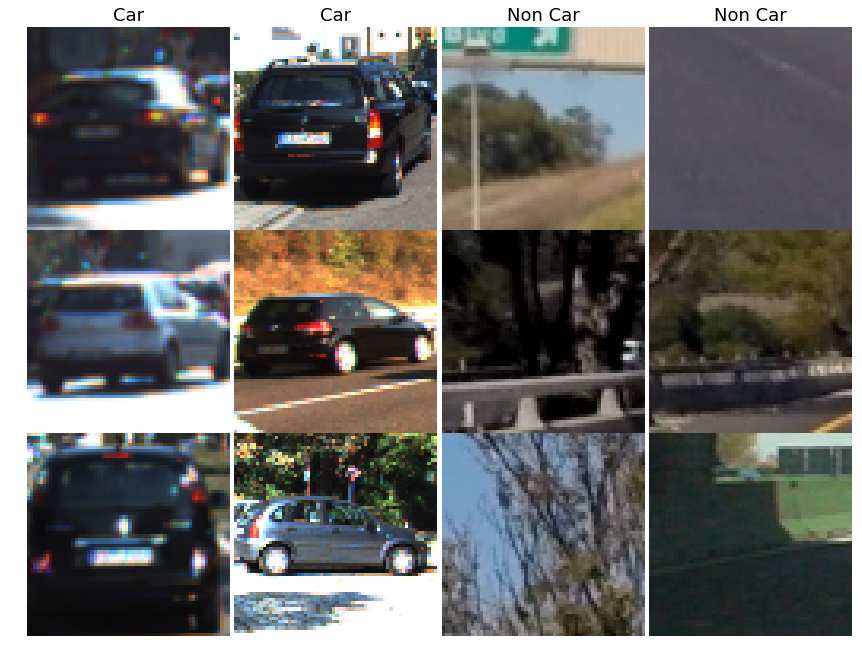

In [4]:
from sklearn.utils import resample

plt_grid_image(zip(resample(car_train, n_samples=3), 
                   resample(car_train, n_samples=3), 
                   resample(noncar_train, n_samples=3),
                   resample(noncar_train, n_samples=3)), 
               (3,4), car_train[0].shape[:2], ['Car', 'Car', 'Non Car', 'Non Car'], 12)
plt.savefig('./output_images/car_noncar.png')

In [5]:
def jitter_crop(img):
    top = np.random.randint(0,64/4)
    left = np.random.randint(0,64/4)
    height = np.random.randint(64/2,64)
    width = np.random.randint(64/2,64)
    bottom = min(top+height, 64)
    right = min(left+width, 64)
    crop = cv2.resize(img[top:bottom, left:right], (64,64))
    y,u,v = cv2.split(cv2.cvtColor(crop, cv2.COLOR_BGR2YUV))
    y = y.astype(int) + np.random.randint(-20,20)
    y = y + np.random.randint(-3,3,y.shape)
    y[y<0] = 0
    y[y>255] = 255
    y = y.astype(np.uint8)
    return cv2.cvtColor(cv2.merge((y,u,v)), cv2.COLOR_YUV2BGR)
    return crop

def augment_data(imgs, n):
    return [jitter_crop(img) for img in resample(imgs, n_samples=n)]

car_train = np.vstack([car_train, augment_data(car_train, len(car_train))])
noncar_train = np.vstack([noncar_train, augment_data(noncar_train, len(noncar_train))])

## Feature extraction

In [6]:
import skimage.feature

def bin_spatial(img, cspace=None, size=(16, 16)):
    # Convert image to new color space (if specified)
    img = cv2.resize(img, size, cv2.INTER_AREA)
    if cspace is not None:
        img = cv2.cvtColor(img, cspace)
    return img.ravel()

def color_histogram(img,cspace=cv2.COLOR_BGR2HSV, bins=32):
    if cspace is not None:
        img = cv2.cvtColor(img, cspace)
    return np.hstack([np.histogram(np.sqrt(channel).ravel(),bins=bins,normed=True)[0] 
                      for channel in cv2.split(img)])
    
def hog(img, orient=12, pix_per_cell=8, cell_per_block=1, vis=False, feature_vec=True):
    return skimage.feature.hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
               visualise=vis, feature_vector=feature_vec)

def hogcv(img, orient=12, pix_per_cell=8, cell_per_block=1):
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // pix_per_cell * pix_per_cell,
                                     img.shape[0] // pix_per_cell * pix_per_cell),
                            _blockSize=(cell_per_block * pix_per_cell,
                                       cell_per_block * pix_per_cell),
                            _blockStride=(pix_per_cell, pix_per_cell),
                            _cellSize=(pix_per_cell, pix_per_cell),
                            _nbins=orient)
    return hog.compute(img).ravel()
            
def extract_features(img):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    return np.hstack([hogcv(luv[:,:,1]), hogcv(luv[:,:,2]), hogcv(luv[:,:,0]), bin_spatial(luv), bin_spatial(img), color_histogram(luv)])

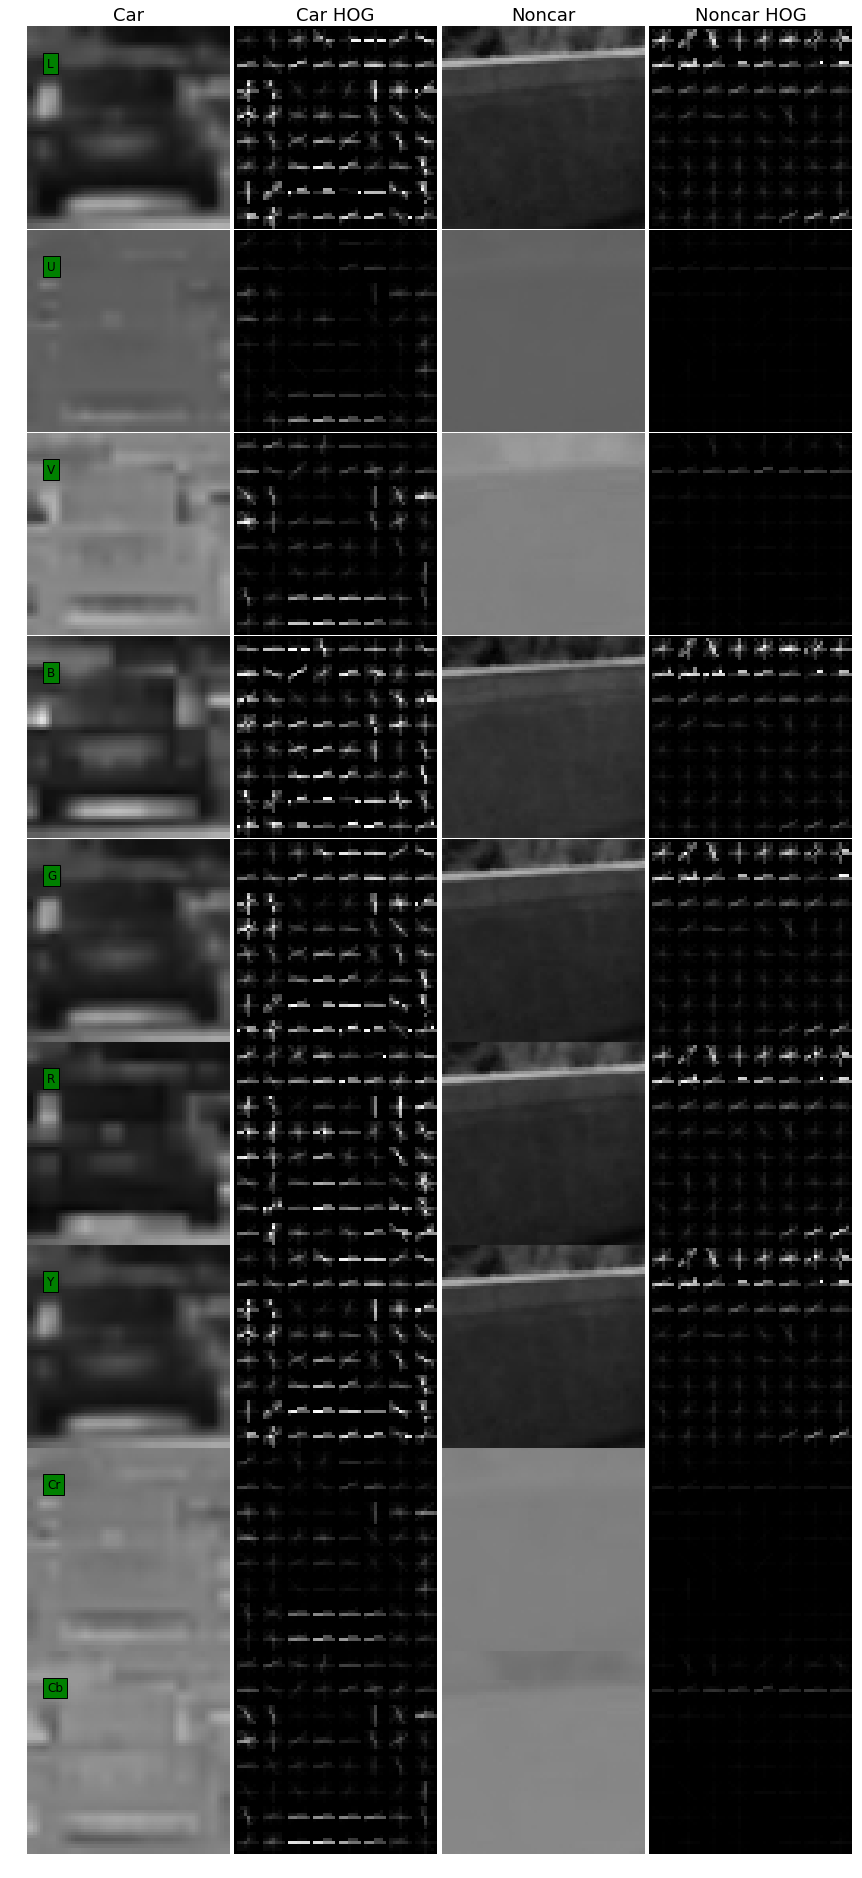

In [7]:
carimg = car_train[100]
noncarimg = noncar_train[200]

carb,carg,carr = cv2.split(carimg)
carl,caru,carv = cv2.split(cv2.cvtColor(carimg, cv2.COLOR_BGR2LUV))
cary,carcr,carcb = cv2.split(cv2.cvtColor(carimg, cv2.COLOR_BGR2YCrCb))

noncarb,noncarg,noncarr = cv2.split(noncarimg)
noncarl,noncaru,noncarv = cv2.split(cv2.cvtColor(noncarimg, cv2.COLOR_BGR2LUV))
noncary,noncarcr,noncarcb = cv2.split(cv2.cvtColor(noncarimg, cv2.COLOR_BGR2YCrCb))

gray2bgr = lambda x: cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
hogvis = lambda x: gray2bgr((hog(x, vis=True)[1]*255).astype(np.uint8))

carhogb = hogvis(carb)
carhogg = hogvis(carg)
carhogr = hogvis(carr) 
carhogl = hogvis(carl) 
carhogu = hogvis(caru)
carhogv = hogvis(carv)
carhogy = hogvis(cary) 
carhogcr = hogvis(carcr)
carhogcb = hogvis(carcb)


noncarhogb = hogvis(noncarb)
noncarhogg = hogvis(noncarg)
noncarhogr = hogvis(noncarr)
noncarhogl = hogvis(noncarl)
noncarhogu = hogvis(noncaru)
noncarhogv = hogvis(noncarv)
noncarhogy = hogvis(noncary) 
noncarhogcr = hogvis(noncarcr)
noncarhogcb = hogvis(noncarcb)

gs = plt_grid_image([[gray2bgr(carl), carhogl, gray2bgr(noncarl), noncarhogl],
                [gray2bgr(caru), carhogu, gray2bgr(noncaru), noncarhogu],
                [gray2bgr(carv), carhogv, gray2bgr(noncarv), noncarhogv],
                [gray2bgr(carb), carhogb, gray2bgr(noncarb), noncarhogb],
                [gray2bgr(carg), carhogg, gray2bgr(noncarg), noncarhogg],
                [gray2bgr(carr), carhogr, gray2bgr(noncarr), noncarhogr],
                [gray2bgr(cary), carhogy, gray2bgr(noncary), noncarhogy],
                [gray2bgr(carcr), carhogcr, gray2bgr(noncarcr), noncarhogcr],
                [gray2bgr(carcb), carhogcb, gray2bgr(noncarcb), noncarhogcb]],
               (9,4), (64,64), ('Car', 'Car HOG', 'Noncar', 'Noncar HOG'), 12)

channel_name = ['L', 'U', 'V', 'B', 'G', 'R', 'Y', 'Cr', 'Cb']
for i in range(len(channel_name)):
    ax = plt.subplot(gs[i*4])
    ax.text(0.1, 0.8, channel_name[i], transform=ax.transAxes, bbox=dict(facecolor='green') ,fontsize=12)
plt.savefig('./output_images/HOG.png')

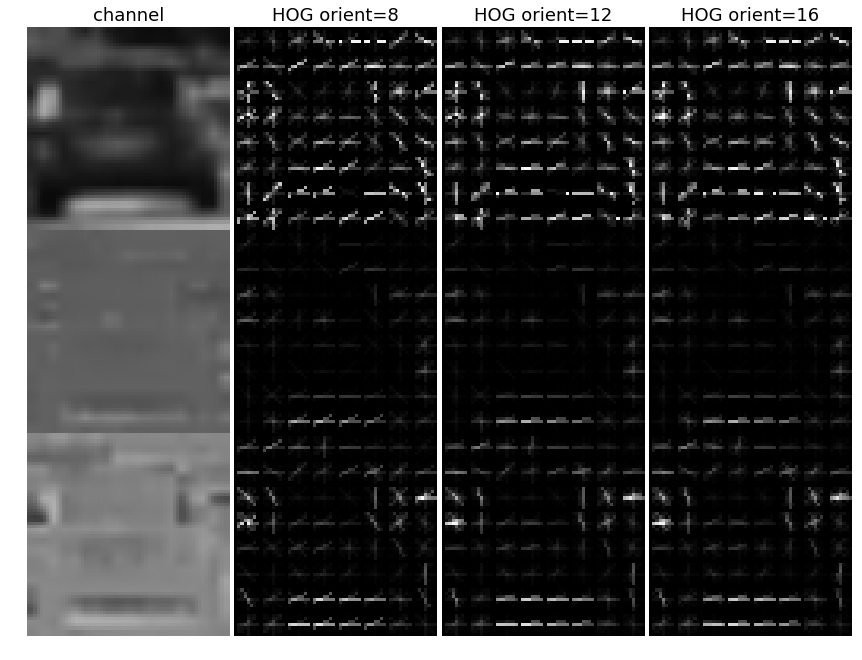

In [8]:
hogvis2 = lambda x, o: gray2bgr((hog(x, orient=o, vis=True)[1]*255).astype(np.uint8))
carhogl8  = hogvis2(carl, 8)
carhogl12 = hogvis2(carl, 12)
carhogl16 = hogvis2(carl, 16)
carhogu8  = hogvis2(caru, 8)
carhogu12 = hogvis2(caru, 12)
carhogu16 = hogvis2(caru, 16)
carhogv8  = hogvis2(carv, 8)
carhogv12 = hogvis2(carv, 12)
carhogv16 = hogvis2(carv, 16)

plt_grid_image([[gray2bgr(carl), carhogl8, carhogl12, carhogl16],
                [gray2bgr(caru), carhogu8, carhogu12, carhogu16],
                [gray2bgr(carv), carhogv8, carhogv12, carhogv16]],
               (3,4), carhogl8.shape[:2], ['channel', 'HOG orient=8', 'HOG orient=12', 'HOG orient=16'])
plt.savefig('./output_images/HOG_orient.png')

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegressionCV

from tqdm import tqdm
features_car_train = [extract_features(img) for img in tqdm(car_train)]
features_noncar_train = [extract_features(img) for img in tqdm(noncar_train)]

features_train = np.array(features_car_train + features_noncar_train)
feature_scaler = StandardScaler().fit(features_train)
scaled_features_train = feature_scaler.transform(features_train)

labels_train = [1]*len(features_car_train) + [0]*len(features_noncar_train)

features_car_test = [extract_features(img) for img in tqdm(car_test)]
features_noncar_test = [extract_features(img) for img in tqdm(noncar_test)]
features_test = np.array(features_car_test + features_noncar_test)
scaled_features_test = feature_scaler.transform(features_test)

labels_test = [1]*len(features_car_test) + [0]*len(features_noncar_test)

100%|██████████| 1800/1800 [00:03<00:00, 479.75it/s]


In [10]:
def process(img):
    features = pack_features(img)
    scaled_features = feature_scaler.transform(features)
#     pca_features = pca.transform(scaled_features)
    pca_features = scaled_features
    return pca_features

# for n_comp in [500, 1000, 1500, 2000, 2500, 3000]:
#     print('='*20)
    
#     pca = PCA(n_components=n_comp)
#     pca.fit(scaled_features_train)
#     print('PCA variation = {:.4f}'.format(sum(pca.explained_variance_ratio_)))
    
#     pca_features_train = pca.transform(scaled_features_train)
# #     svc = SVC(tol=1e-8, C=1e3, kernel='poly')
#     svc = LinearSVC(tol=1e-8, C=1e-4)
#     pca_features_test = pca.transform(scaled_features_test)

#     svc.fit(pca_features_train, labels_train)
#     pred_labels = svc.predict(pca_features_test)
#     print('Test Precision of SVC = ', round(precision_score(labels_test, pred_labels), 4))
#     print('Test Recall of SVC = ', round(recall_score(labels_test, pred_labels), 4))
#     print('Test Accuracy of SVC = ', round(accuracy_score(labels_test, pred_labels), 4))

class mockPCA:
    def transform(self, x):
        return x
    
pca = mockPCA()
# pca = PCA(n_components=3000)
# pca.fit(scaled_features_train)

svc = LinearSVC(tol=1e-8, C=1e-4)
# svc = SVC(C=1e4, kernel='poly')

pca_features_train = pca.transform(scaled_features_train)
svc.fit(pca_features_train, labels_train)

pca_features_test = pca.transform(scaled_features_test)
pred_labels = svc.predict(pca_features_test)
print('Test Precision of SVC = ', round(precision_score(labels_test, pred_labels), 4))
print('Test Recall of SVC = ', round(recall_score(labels_test, pred_labels), 4))
print('Test Accuracy of SVC = ', round(accuracy_score(labels_test, pred_labels), 4))


Test Precision of SVC =  0.9744
Test Recall of SVC =  0.9943
Test Accuracy of SVC =  0.9843


In [11]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)        
    return imcopy

def slide_window(img_shape, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    x_start, x_stop = x_start_stop
    y_start, y_stop = x_start_stop
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img_shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img_shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = min(startx + xy_window[0], img_shape[1]-1)
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = min(starty + xy_window[1], img_shape[0]-1)
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


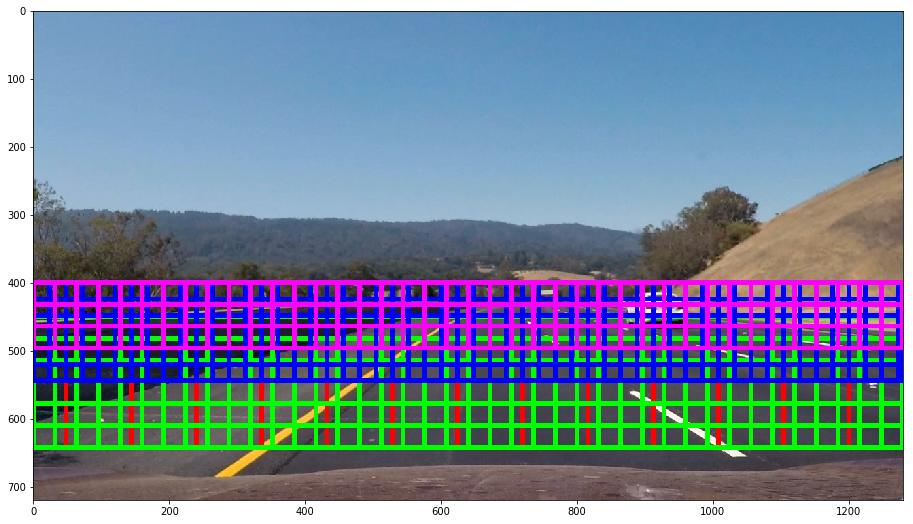

In [12]:
img = cv2.imread('./test_images/test3.jpg')
img_shape = img.shape

windows192 = slide_window(img_shape, y_start_stop=[450, 580], 
                            xy_window=(192, 192), xy_overlap=(0.75, 0.75))
windows128 = slide_window(img_shape, y_start_stop=[450, 600], 
                            xy_window=(128, 128), xy_overlap=(0.75, 0.75))
windows96 = slide_window(img_shape, y_start_stop=[400, 500], 
                            xy_window=(96, 96), xy_overlap=(0.75, 0.75))
windows64 = slide_window(img_shape, y_start_stop=[400, 500], 
                            xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows = windows64 + windows96 + windows128 + windows192

bboxed_img = draw_boxes(img, windows192)
bboxed_img = draw_boxes(bboxed_img, windows128, (0,255,0))
bboxed_img = draw_boxes(bboxed_img, windows96, (255,0,0))
bboxed_img = draw_boxes(bboxed_img, windows64, (255,0,255))
plt.figure(figsize=(16,9))
plt.imshow(RGB(bboxed_img))
plt.savefig('./output_images/windows.png')

In [13]:
def extract_features_from_windows(img, windows):
    features = []
    for (x0,y0), (x1,y1) in windows:
        patch = cv2.resize(img[y0:y1,x0:x1], (64,64))
        features.append(extract_features(patch))
    return features

def batch_extract_simple_features_from_windows(img, windows, binsize=(16,16)):
    binh, binw = binsize
    imgh, imgw = img.shape[:2]
    
    windows=np.int_(windows)
    wsize = np.diff(windows,axis=1).squeeze()
    unique_wsize = np.vstack({tuple(row) for row in wsize})
    
    patches = [None]*len(windows)
    
    for winw, winh in unique_wsize:
        rs_img = cv2.resize(img, (binw*imgw//winw+1,binh*imgh//winh+1))            
        idx, = np.where((wsize[:,0]==winh) &  (wsize[:,1]==winw))        
        topleft = windows[idx][:,0,:]*[binw,binh]//[winw,winh]
        for (x, y), i in zip(topleft, range(len(idx))):
            patches[idx[i]] = rs_img[y:y+binh,x:x+binw]

    return np.array(patches).reshape(len(windows),-1)

def detect_veh(img, windows=windows):
    if not windows:
        return []
    features = extract_features_from_windows(img, windows)
    idx, = np.where(svc.predict(pca.transform(feature_scaler.transform(features)))>0.5)
#     idx, = np.where(svc.predict(feature_scaler.transform(features))>0.5)
    return [windows[i] for i in idx]

def add_heat(img_shape, windows):
    heatmap = np.zeros(img_shape[:2], dtype=int)
    for (x0,y0), (x1,y1) in windows:
        heatmap[y0:y1, x0:x1] += 1
    return heatmap

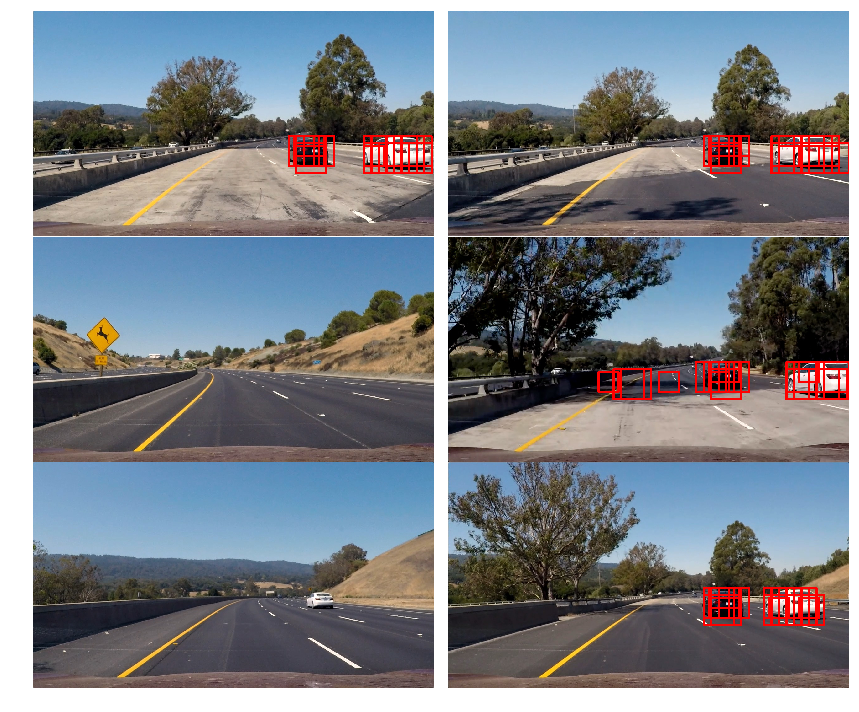

In [14]:
test_imgs = [cv2.imread(img_name) for img_name in sorted(glob('test_images/*.jpg'))]
detected_windows = [detect_veh(img) for img in test_imgs]
bboxed_imgs = [draw_boxes(img, window) for img, window in zip(test_imgs, detected_windows)]
heatmap = [add_heat(test_imgs[0].shape[:2], window) for window in detected_windows]

plt_grid_image(zip(bboxed_imgs[:3], bboxed_imgs[3:]), (3,2), (test_imgs[0].shape[:2]), ['',''])
plt.savefig('./output_images/bboxes.png')

In [15]:
import scipy.ndimage.measurements
from queue import Queue

to_cmap_hot = lambda x: cv2.cvtColor((plt.cm.hot(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)/255)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
to_cmap_accent = lambda x: cv2.cvtColor((plt.cm.Accent(x)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)

class History:
    def __init__(self):
        self.heatmaps = Queue(8)
        self.intheatmaps = Queue(8)
        self.lastintheatmap = None
        self.bboxes = []
        self.count = 0
        self.decay = 0.8
        self.result = None
        self.count = 0
        
    def neighborhood_bboxes(self, windows):
        intersection = []
        for (x0,y0), (x1,y1) in self.bboxes:
            center_x = (x0 + x1)//2
            center_y = (y0 + y1)//2
            for (wx0, wy0), (wx1, wy1) in windows:
                if (abs(wx0 - center_x) <= 128 and abs(wx1 - center_x) <= 128
                    and abs(wy0 - center_y) <= 128 and abs(wy1 - center_y) <= 128):
                    intersection.append(((wx0, wy0), (wx1, wy1)))
        return intersection
        
    def update(self, img):
        search_windows = windows if self.count%5 == 0 else self.neighborhood_bboxes(windows)
        self.count += 1
        new_bboxes = detect_veh(img, search_windows) 
        
        new_heatmap = add_heat(img.shape, new_bboxes)
        self.lastintheatmap = new_heatmap if self.lastintheatmap is None else new_heatmap*0.2 + self.lastintheatmap*0.9

        if(self.heatmaps.full()): self.heatmaps.get()
        self.heatmaps.put(new_heatmap)

        if(self.intheatmaps.full()): self.intheatmaps.get()
        self.intheatmaps.put(self.lastintheatmap)
        
        labels = scipy.ndimage.measurements.label(self.lastintheatmap>2)
        
        heatmap_img = gray2bgr((new_heatmap/(new_heatmap.max()+2)*255).astype(np.uint8))
        intheatmap_img = gray2bgr((self.lastintheatmap/(self.lastintheatmap.max()+2)*255).astype(np.uint8))

        self.bboxes = []
        for veh in range(1, labels[1]+1):
            nonzeroy, nonzerox = (labels[0] == veh).nonzero()
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            if bbox[1][0] - bbox[0][0] > 32 and bbox[1][1]-bbox[0][1] > 32:
                self.bboxes.append(bbox)
                
        bboxed_img = draw_boxes(img, self.bboxes)
        labeled_img = to_cmap_hot(cv2.cvtColor((labels[0]/(labels[0].max()+0.01)*255).astype(np.uint8), cv2.COLOR_GRAY2BGR))
        
        if self.count > 930 and self.count < 960:
            cv2.imwrite('./output_images/img{}.png'.format(self.count), img)
            cv2.imwrite('./output_images/heatmap{}.png'.format(self.count), heatmap_img)
            cv2.imwrite('./output_images/intheatmap{}.png'.format(self.count), intheatmap_img)
            cv2.imwrite('./output_images/bboxed{}.png'.format(self.count), bboxed_img)
            cv2.imwrite('./output_images/labels{}.png'.format(self.count), labeled_img)
            
        intheatmap_img = to_cmap_hot(cv2.resize(intheatmap_img, (intheatmap_img.shape[1]//4, intheatmap_img.shape[0]//4)))
        bboxed_img[:intheatmap_img.shape[0],:intheatmap_img.shape[1]] = intheatmap_img
        return bboxed_img
        
        

In [16]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

his = History()

rgb2bgr = lambda x: cv2.cvtColor(x, cv2.COLOR_RGB2BGR)
input_name = './project_video.mp4'
output_name = './project_video_out.mp4'
clip1 = VideoFileClip(input_name)
white_clip = clip1.fl_image(lambda x: RGB(his.update(rgb2bgr(x)))) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_name, audio=False)

[MoviePy] >>>> Building video ./project_video_out.mp4
[MoviePy] Writing video ./project_video_out.mp4


100%|█████████▉| 1260/1261 [07:17<00:00,  2.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_out.mp4 

CPU times: user 11min 13s, sys: 9min 49s, total: 21min 2s
Wall time: 7min 17s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>

""".format(output_name))

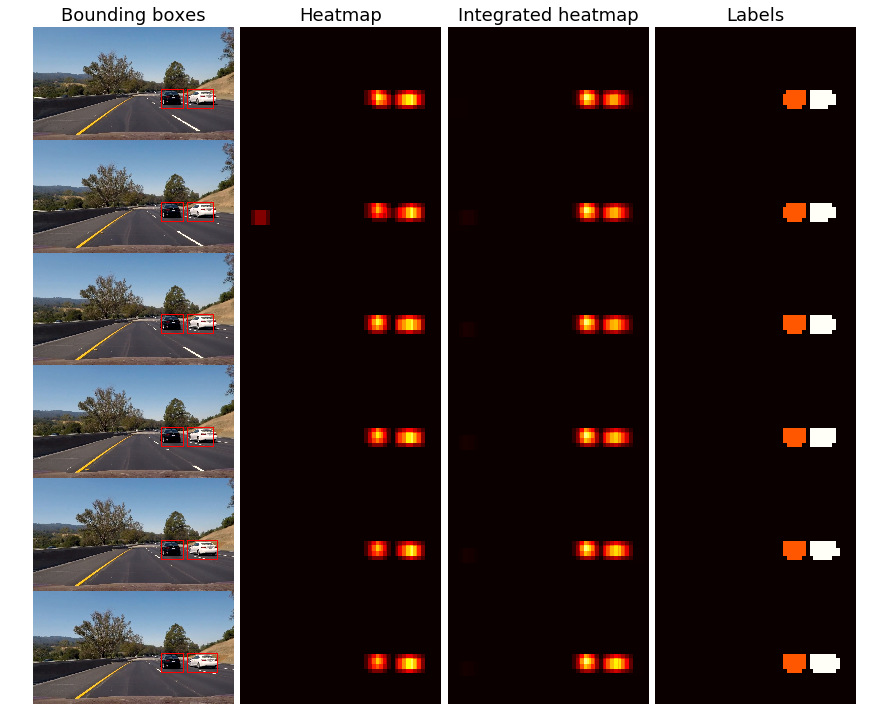

In [18]:
to_cmap_hot = lambda x: cv2.cvtColor((plt.cm.hot(cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)/255)[...,:3]*255).astype(np.uint8), cv2.COLOR_RGB2BGR)
gs = plt_grid_image([[cv2.imread('./output_images/bboxed{}.png'.format(i)), 
                 to_cmap_hot(cv2.imread('./output_images/heatmap{}.png'.format(i))), 
                 to_cmap_hot(cv2.imread('./output_images/intheatmap{}.png'.format(i))),
                     cv2.imread('./output_images/labels{}.png'.format(i))] for i in range(950, 956)],
               (6,4), img_shape[:2], ('Bounding boxes', 'Heatmap', 'Integrated heatmap', 'Labels'), 12)

plt.savefig('./output_images/heatmap_6frames.png')